![](https://malikkhubiev.github.io/pngs/devim_logo.svg)

In [ ]:
# ======================
# 0. Импорт библиотек
# ======================
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# ======================
# 1. Загрузка данных
# ======================
payments = pd.read_csv("payments.csv")
plan = pd.read_csv("plan.csv")
orders = pd.read_csv("orders.csv")

In [ ]:
# ======================
# 2. Преобразование дат
# ======================
payments["paid_at"] = pd.to_datetime(payments["paid_at"], errors="coerce")
plan["plan_at"] = pd.to_datetime(plan["plan_at"], errors="coerce")
orders["created_at"] = pd.to_datetime(orders["created_at"], errors="coerce")
orders["put_at"] = pd.to_datetime(orders["put_at"], errors="coerce")
orders["closed_at"] = pd.to_datetime(orders["closed_at"], errors="coerce")

In [ ]:
# ======================
# 3. Объединение данных и расчёт просрочки
# ======================
merged = pd.merge(plan, payments, on="order_id", how="left")

print(merged)

          order_id    plan_at  plan_sum_total                 paid_at  \
0        400001732 2022-06-02         5600.00 2022-06-02 20:20:16.790   
1        400001732 2022-06-02         5600.00 2022-06-16 16:05:26.007   
2        400001732 2022-06-02         5600.00 2022-07-15 12:32:34.087   
3        400001732 2022-06-02         5600.00 2022-08-16 12:38:01.237   
4        400001732 2022-06-02         5600.00 2022-09-15 12:14:48.867   
...            ...        ...             ...                     ...   
1483583  495177509 2023-02-20        44484.12 2022-10-19 03:38:53.250   
1483584  495177509 2023-02-20        44484.12 2022-10-21 01:13:10.547   
1483585  495177509 2023-02-20        44484.12 2022-10-21 05:23:00.557   
1483586  495177509 2023-02-20        44484.12 2022-10-23 15:21:43.243   
1483587  495177509 2023-02-20        44484.12 2022-10-24 13:10:53.557   

         paid_sum  
0         5600.00  
1         3850.00  
2         2720.00  
3         2720.00  
4         2720.00  
...

In [ ]:
# Накопленный итог оплат
merged["paid_cumsum"] = merged.groupby("order_id")["paid_sum"].cumsum()

print(merged.head(5))

    order_id    plan_at  plan_sum_total                 paid_at  paid_sum  \
0  400001732 2022-06-02          5600.0 2022-06-02 20:20:16.790    5600.0   
1  400001732 2022-06-02          5600.0 2022-06-16 16:05:26.007    3850.0   
2  400001732 2022-06-02          5600.0 2022-07-15 12:32:34.087    2720.0   
3  400001732 2022-06-02          5600.0 2022-08-16 12:38:01.237    2720.0   
4  400001732 2022-06-02          5600.0 2022-09-15 12:14:48.867    2720.0   

   paid_cumsum  
0       5600.0  
1       9450.0  
2      12170.0  
3      14890.0  
4      17610.0  


In [ ]:
# Долг на дату планового платежа
merged["debt"] = merged["plan_sum_total"] - merged["paid_cumsum"].fillna(0)

print(merged[["plan_sum_total", "paid_cumsum", "debt"]])

         plan_sum_total  paid_cumsum       debt
0               5600.00      5600.00       0.00
1               5600.00      9450.00   -3850.00
2               5600.00     12170.00   -6570.00
3               5600.00     14890.00   -9290.00
4               5600.00     17610.00  -12010.00
...                 ...          ...        ...
1483583        44484.12    468540.20 -424056.08
1483584        44484.12    471265.52 -426781.40
1483585        44484.12    473953.85 -429469.73
1483586        44484.12    476605.18 -432121.06
1483587        44484.12    479219.52 -434735.40

[1483588 rows x 3 columns]


In [ ]:
# Просрочка (если долг > 0 и оплата позже даты плана)
merged["delay_days"] = (merged["paid_at"] - merged["plan_at"]).dt.days
merged["is_overdue"] = (merged["debt"] > 0) & (
    (merged["delay_days"].isna()) | (merged["delay_days"] > 0)
)

print(merged[["paid_at", "plan_at", "delay_days", "debt", "is_overdue"]])
print(merged["is_overdue"].value_counts())

                        paid_at    plan_at  delay_days       debt  is_overdue
0       2022-06-02 20:20:16.790 2022-06-02         0.0       0.00       False
1       2022-06-16 16:05:26.007 2022-06-02        14.0   -3850.00       False
2       2022-07-15 12:32:34.087 2022-06-02        43.0   -6570.00       False
3       2022-08-16 12:38:01.237 2022-06-02        75.0   -9290.00       False
4       2022-09-15 12:14:48.867 2022-06-02       105.0  -12010.00       False
...                         ...        ...         ...        ...         ...
1483583 2022-10-19 03:38:53.250 2023-02-20      -124.0 -424056.08       False
1483584 2022-10-21 01:13:10.547 2023-02-20      -122.0 -426781.40       False
1483585 2022-10-21 05:23:00.557 2023-02-20      -122.0 -429469.73       False
1483586 2022-10-23 15:21:43.243 2023-02-20      -120.0 -432121.06       False
1483587 2022-10-24 13:10:53.557 2023-02-20      -119.0 -434735.40       False

[1483588 rows x 5 columns]
is_overdue
False    1464296
True    

In [ ]:
# ======================
# 4. Агрегация по месяцам
# ======================
monthly = merged.groupby(merged["plan_at"].dt.to_period("M")).agg(
    total_payments=("order_id", "count"),
    overdue=("is_overdue", "sum"),
    avg_delay_days=("delay_days", "mean"),
)
monthly["overdue_rate"] = monthly["overdue"] / monthly["total_payments"]
monthly = monthly.reset_index()
monthly["plan_at"] = monthly["plan_at"].dt.to_timestamp()

print(monthly)

      plan_at  total_payments  overdue  avg_delay_days  overdue_rate
0  2022-06-01           60329      984       32.488521      0.016311
1  2022-07-01          146224     2305       19.185527      0.015763
2  2022-08-01          225306     3220        3.443552      0.014292
3  2022-09-01          228310     2890      -22.712486      0.012658
4  2022-10-01          230856     2687      -53.643941      0.011639
5  2022-11-01          223048     2560      -84.181690      0.011477
6  2022-12-01          201401     2389     -108.664258      0.011862
7  2023-01-01          123281     1567     -125.689855      0.012711
8  2023-02-01           43301      663     -140.977555      0.015311
9  2023-03-01            1480       27     -147.245699      0.018243
10 2023-04-01              22        0     -191.454545      0.000000
11 2023-05-01              22        0     -221.454545      0.000000
12 2023-06-01               8        0     -252.625000      0.000000


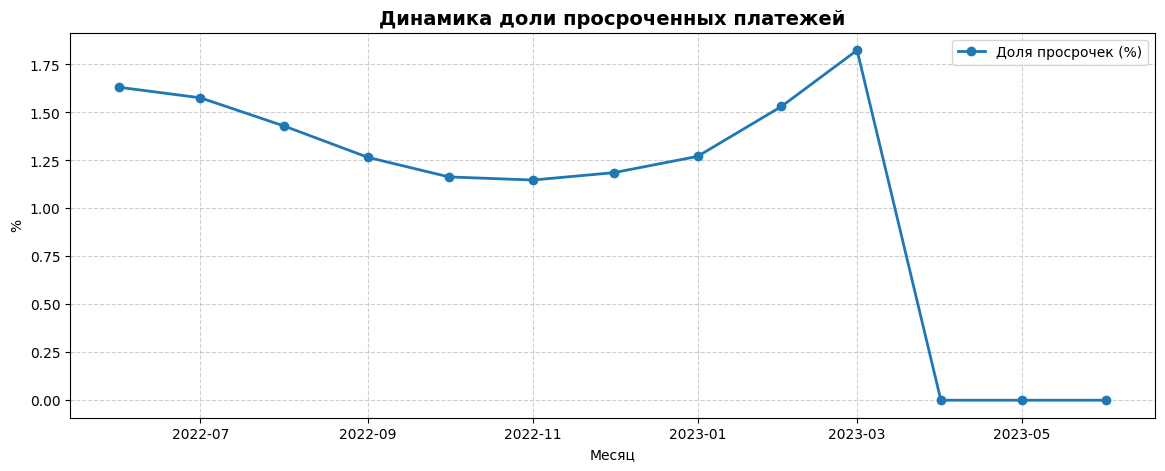

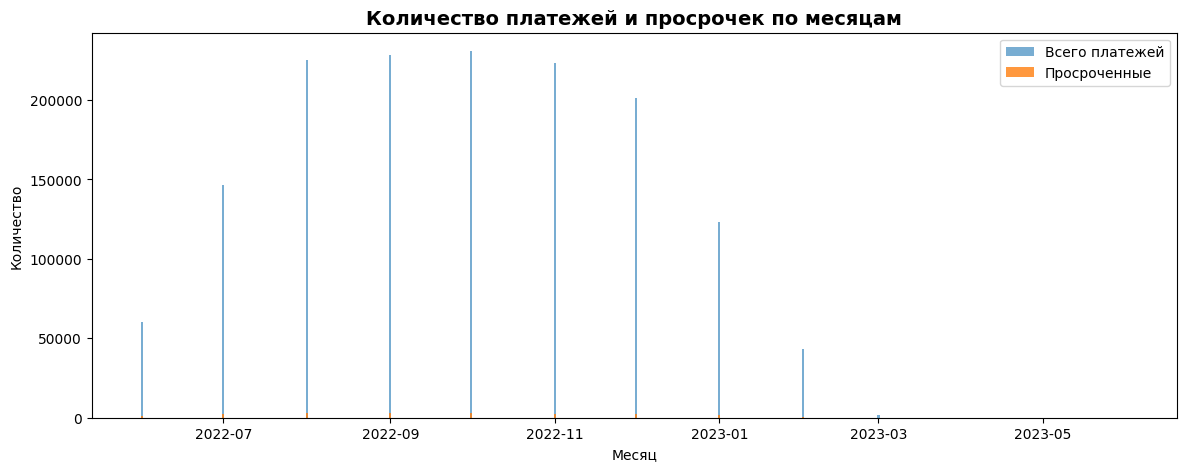

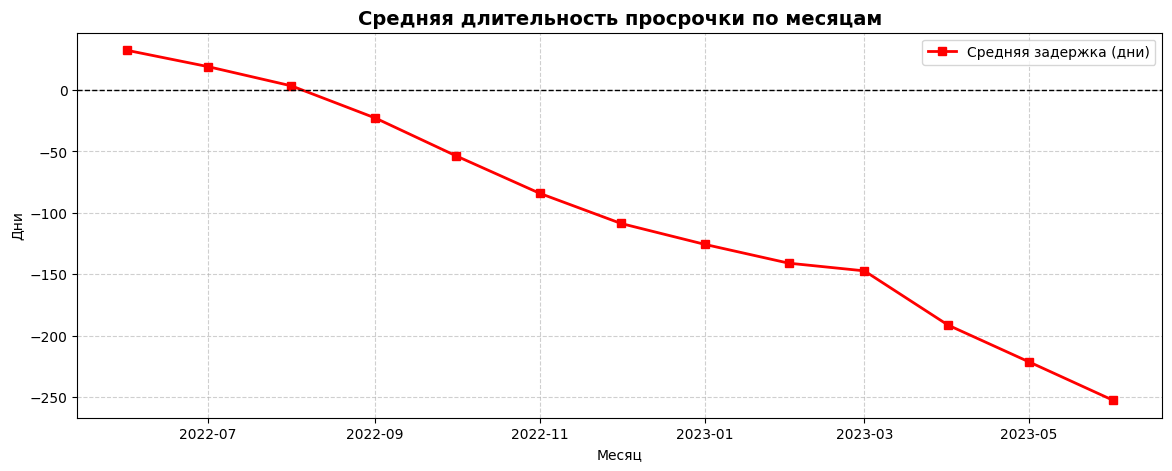

In [ ]:
# ======================
# 5. Визуализация
# ======================
plt.figure(figsize=(14, 5))
plt.plot(
    monthly["plan_at"], monthly["overdue_rate"] * 100, marker="o", linewidth=2, label="Доля просрочек (%)"
)
plt.title("Динамика доли просроченных платежей", fontsize=14, weight="bold")
plt.xlabel("Месяц")
plt.ylabel("%")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.bar(monthly["plan_at"], monthly["total_payments"], alpha=0.6, label="Всего платежей")
plt.bar(monthly["plan_at"], monthly["overdue"], alpha=0.8, label="Просроченные")
plt.title("Количество платежей и просрочек по месяцам", fontsize=14, weight="bold")
plt.xlabel("Месяц")
plt.ylabel("Количество")
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(
    monthly["plan_at"], monthly["avg_delay_days"], marker="s", color="red", linewidth=2, label="Средняя задержка (дни)"
)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title("Средняя длительность просрочки по месяцам", fontsize=14, weight="bold")
plt.xlabel("Месяц")
plt.ylabel("Дни")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [ ]:
percent_df = monthly.copy()
percent_df["overdue_rate"] *= 100
print(percent_df)

      plan_at  total_payments  overdue  avg_delay_days  overdue_rate
0  2022-06-01           60329      984       32.488521      1.631056
1  2022-07-01          146224     2305       19.185527      1.576349
2  2022-08-01          225306     3220        3.443552      1.429167
3  2022-09-01          228310     2890      -22.712486      1.265823
4  2022-10-01          230856     2687      -53.643941      1.163929
5  2022-11-01          223048     2560      -84.181690      1.147735
6  2022-12-01          201401     2389     -108.664258      1.186191
7  2023-01-01          123281     1567     -125.689855      1.271080
8  2023-02-01           43301      663     -140.977555      1.531142
9  2023-03-01            1480       27     -147.245699      1.824324
10 2023-04-01              22        0     -191.454545      0.000000
11 2023-05-01              22        0     -221.454545      0.000000
12 2023-06-01               8        0     -252.625000      0.000000


In [ ]:
# ======================
# 6. Итоговые выводы
# ======================
summary = {
    "минимальная_доля_просрочки": f"{monthly['overdue_rate'].min()*100:.2f}% ({monthly.loc[monthly['overdue_rate'].idxmin(), 'plan_at'].strftime('%B %Y')})",
    "максимальная_доля_просрочки": f"{monthly['overdue_rate'].max()*100:.2f}% ({monthly.loc[monthly['overdue_rate'].idxmax(), 'plan_at'].strftime('%B %Y')})",
    "текущая_тенденция": "рост" if monthly["overdue_rate"].iloc[-1] > monthly["overdue_rate"].iloc[-3] else "снижение/стабильность",
    "средняя_просрочка_дни": f"{monthly['avg_delay_days'].mean():.1f}",
}

summary

{'минимальная_доля_просрочки': '0.00% (April 2023)',
 'максимальная_доля_просрочки': '1.82% (March 2023)',
 'текущая_тенденция': 'снижение/стабильность',
 'средняя_просрочка_дни': '-99.5'}

# **Динамика просрочки**

Июнь 2022: 1.63% просроченных платежей.

Июль 2022: 1.58% (снижение). ↓

Август 2022: 1.43% (снижение). ↓

Сентябрь 2022: 1.27% (снижение). ↓

Октябрь 2022: 1.16% (снижение). ↓

Ноябрь 2022: 1.15% (стабилизация). →

Декабрь 2022: 1.19% (небольшой рост). ↑

Январь 2023: 1.27% (рост). ↑

Февраль 2023: 1.53% (рост). ↑

Март 2023: 1.82% (дальнейший рост). ↑↑

После апреля 2023 данные практически отсутствуют (очевидно, кредиты закрыты или выдачи прекратились).

# **Выводы**

С июня по ноябрь 2022 наблюдается устойчивое снижение просрочек (с 1.63% до 1.15%).

Декабрь 2022 – март 2023 — тренд меняется: просрочка начинает расти.

На конец периода (март 2023) просрочка уже выше, чем в середине 2022 года (1.82% против 1.15%).

В апреле–июне 2023 почти нет данных, можно предположить сворачивание программы или выборку тестового характера.

Характер поведения клиентов можно описать так:

В первой половине периода дисциплина улучшалась, клиенты платили всё более вовремя.

Во второй половине (зима–весна 2023) ситуация ухудшилась: клиенты стали чаще задерживать платежи.